# Pix2Pix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import TensorFlow and other libraries

In [ ]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


import os
import time

from matplotlib import pyplot as plt
from IPython import display

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Load the dataset & Input Pipeline

In [ ]:
!git clone git://github.com/chaeb/Reconstruct-Masked-Face.git

Cloning into 'Reconstruct-Masked-Face'...
remote: Enumerating objects: 9008, done.
remote: Total 9008 (delta 0), reused 0 (delta 0), pack-reused 9008
Receiving objects: 100% (9008/9008), 144.84 MiB | 23.00 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Checking out files: 100% (9000/9000), done.


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/DL/proj')
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/DL/proj']


In [ ]:
import load_data

In [ ]:
train_mask_image, train_image, val_mask_image, val_image, test_mask_image, test_image = load_data.get('/content/Reconstruct-Masked-Face')

Train no mask image shape: (3500, 128, 128, 3)
Validation no mask image shape: (500, 128, 128, 3)
Test no mask image shape (500, 128, 128, 3)


In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_mask_image, train_image))
test_dataset = tf.data.Dataset.from_tensor_slices((test_mask_image, test_image))

In [ ]:
train_dataset

<TensorSliceDataset shapes: ((128, 128, 3), (128, 128, 3)), types: (tf.float32, tf.float32)>

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (bs, 64, 64, 64)
    downsample(128, 4),  # (bs, 32, 32, 128)
    downsample(256, 4),  # (bs, 16, 16, 256)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512, 4),  # (bs, 16, 16, 1024)
    upsample(256, 4),  # (bs, 32, 32, 512)
    upsample(128, 4),  # (bs, 64, 64, 256)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 128, 128, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

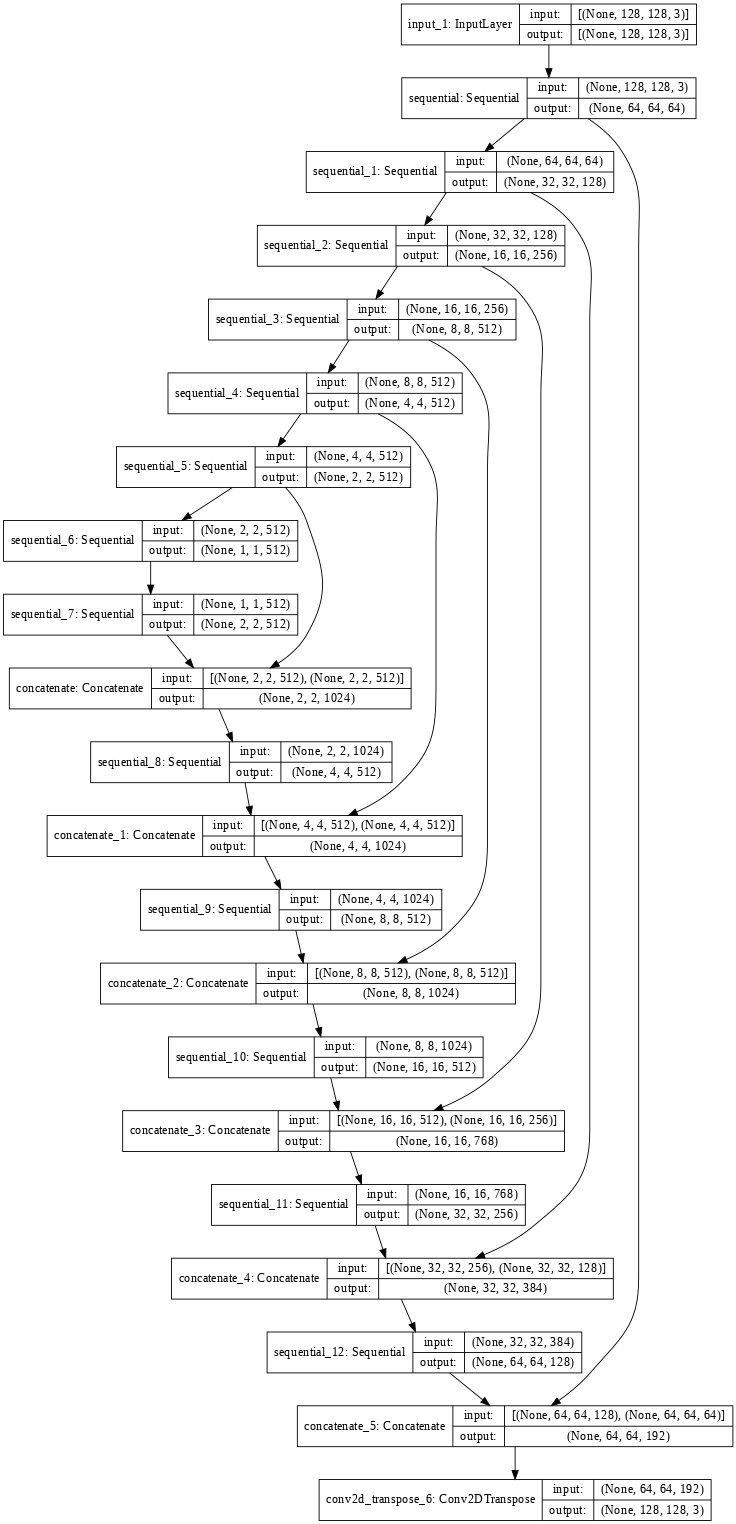

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * Concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 128, 128, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 64, 64, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 32, 32, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 16, 16, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 18, 18, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 21, 21, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 17, 17, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 14, 14, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

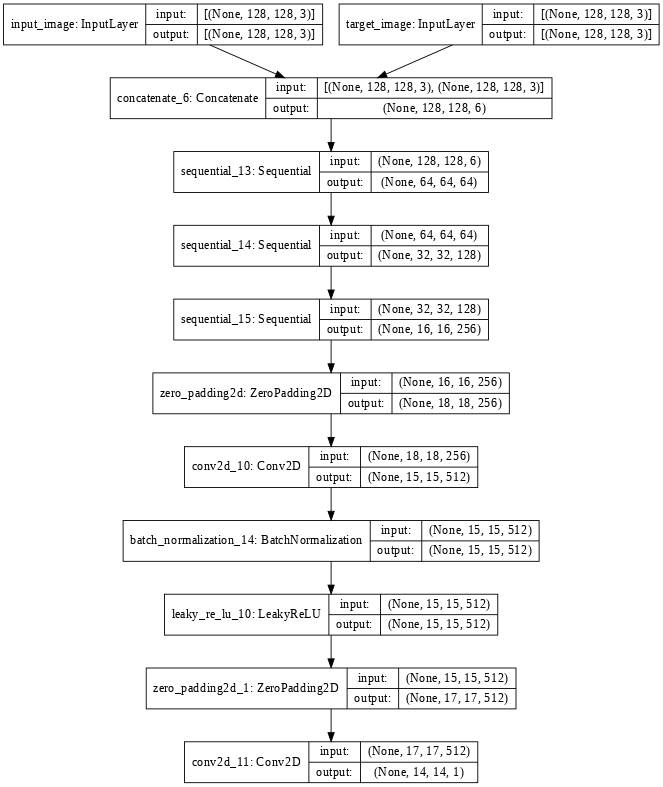

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/DL/proj/pix2pix_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

Write a function to plot some images during training.

* Pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
you want the batch statistics while running the model
on the test dataset. If you use training=False, you get
the accumulated statistics learned from the training dataset
(which you don't want)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [ ]:
def fit_generate_images(model, test_input, tar, epoch):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']  
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    if i != 2 :
      plt.imshow(display_list[i])
      plt.axis('off')
    else :
      plt.imshow(display_list[i])
      plt.savefig('/content/drive/MyDrive/DL/proj/test_pred_img/'+str(epoch)+'.jpg')
      plt.axis('off')
  plt.show()

In [ ]:
# for example_input, example_target in test_dataset.take(1):
#   generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, calculate the generator and the discriminator loss.
* Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [ ]:
EPOCHS = 100

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      fit_generate_images(generator, example_input, example_target, epoch)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      i = ((100*n)/3500)
      if i%10 == 0 :
        print('-',end='')
      train_step(input_image, target, epoch)
    print()
    for no_mask, mask in train_dataset.take(1) :
      plt.subplot(1,2,1)
      plt.imshow(no_mask[0])
      plt.subplot(1,2,2)
      plt.imshow(mask[0])
    plt.show()
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [ ]:
# #docs_infra: no_execute
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Now run the training loop:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


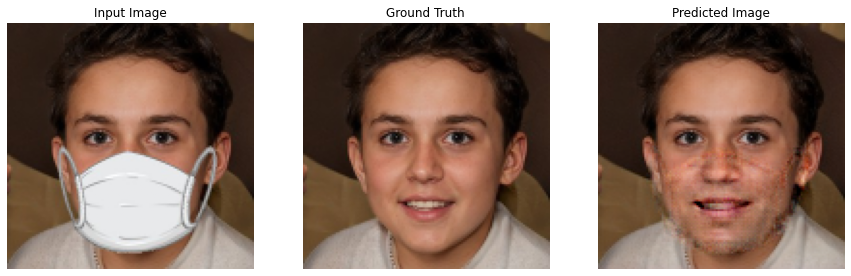

Epoch:  99
----------


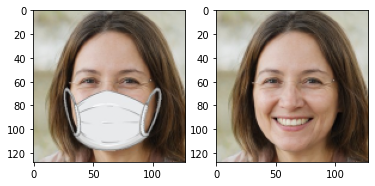

Time taken for epoch 100 is 351.17861771583557 sec



In [ ]:
fit(train_dataset, 100, test_dataset)

## Restore the latest checkpoint and test

In [ ]:
!ls {checkpoint_dir}

checkpoint		     ckpt-5.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-5.index
ckpt-10.index		     ckpt-6.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-6.index
ckpt-1.index		     ckpt-7.data-00000-of-00001
ckpt-2.data-00000-of-00001   ckpt-7.index
ckpt-2.index		     ckpt-8.data-00000-of-00001
ckpt-3.data-00000-of-00001   ckpt-8.index
ckpt-3.index		     ckpt-9.data-00000-of-00001
ckpt-4.data-00000-of-00001   ckpt-9.index
ckpt-4.index


In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

In [ ]:
def generate_images_test(model, test_input, tar):
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(10):
  generate_images_test(generator, inp, tar)

Output hidden; open in https://colab.research.google.com to view.

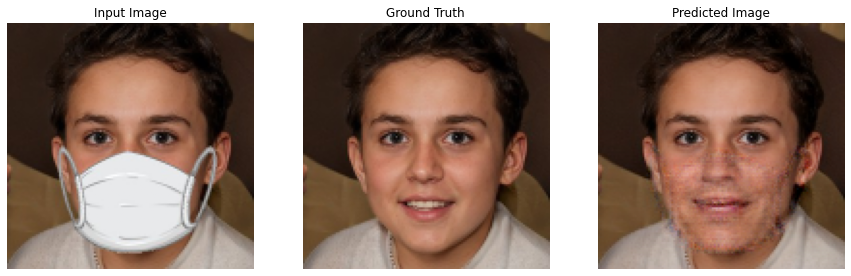

Epoch:  39
--

In [ ]:
fit2(train_dataset, 100, test_dataset)

In [ ]:
checkpoint_dir4 = '/content/drive/MyDrive/DL/proj/pix2pix_checkpoints4'
checkpoint_prefix4 = os.path.join(checkpoint_dir4, "ckpt")
checkpoint4 = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def fit4(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      fit_generate_images4(generator, example_input, example_target, epoch)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      i = ((100*n)/3500)
      if i%10 == 0 :
        print('-',end='')
      train_step(input_image, target, epoch)
    print()
    for no_mask, mask in train_dataset.take(1) :
      plt.subplot(1,2,1)
      plt.imshow(no_mask[0])
      plt.subplot(1,2,2)
      plt.imshow(mask[0])
    plt.show()
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint4.save(file_prefix=checkpoint_prefix4)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint4.save(file_prefix=checkpoint_prefix3)

def fit_generate_images4(model, test_input, tar, epoch):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']  
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    if i != 2 :
      plt.imshow(display_list[i])
      plt.axis('off')
    else :
      plt.imshow(display_list[i])
      plt.savefig('/content/drive/MyDrive/DL/proj/test_pred_img4/'+str(epoch+180)+'.jpg')
      plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


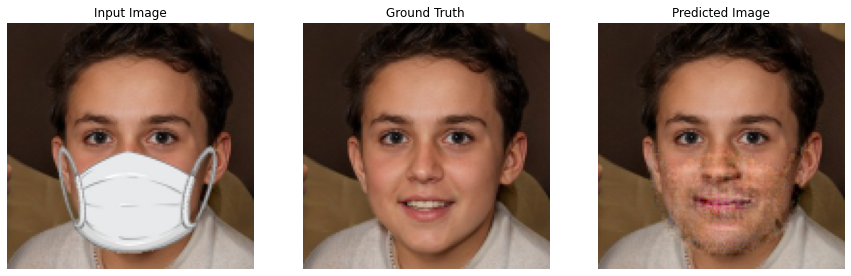

Epoch:  99
----------


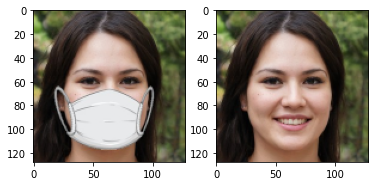

Time taken for epoch 100 is 227.62393283843994 sec



In [ ]:
fit4(train_dataset, 100, test_dataset)

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(10):
  generate_images_test(generator, inp, tar)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
from PIL import Image

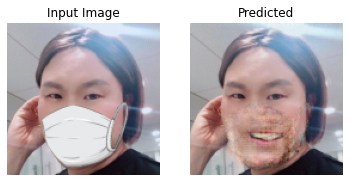

In [ ]:
name = 'YM6'
im = Image.open('/content/'+name+'.JPEG')

imResize = im.resize((256,256), Image.ANTIALIAS)
imResize.save('/content/'+name+'_resized.jpg','JPEG',quality=90)

YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)

YM = cv2.resize(YM, (SIZE, SIZE))

# normalizing image 
YM = YM.astype('float32') / 255.0

YM = YM.reshape(1,128,128,3)

YM_test = tf.data.Dataset.from_tensor_slices(YM)
YM_test = YM_test.batch(BATCH_SIZE)
for inp in YM_test.take(1):
  prediction = generator(inp, training=True)
  display_list = [inp[0], prediction[0]]
  title = ['Input Image', 'Predicted'] 
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

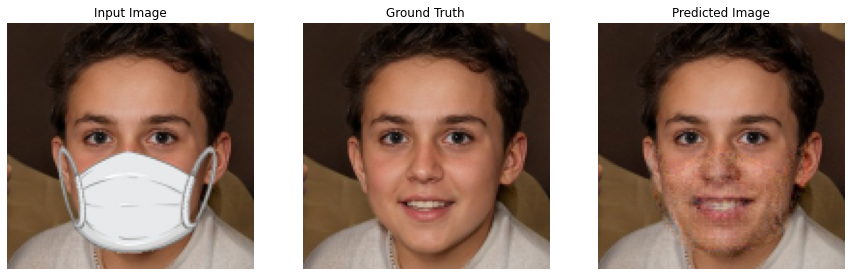

Epoch:  85
--

In [ ]:
fit3(train_dataset, 100, test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


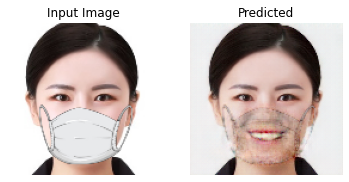

In [ ]:
YM = cv2.imread('/content/CB_test.JPEG',1)
SIZE=128
YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)

YM = cv2.resize(YM, (SIZE, SIZE))

# normalizing image 
YM = YM.astype('float32') / 255.0
YM = YM.reshape(1,128,128,3)
YM_test = tf.data.Dataset.from_tensor_slices(YM)
YM_test = YM_test.batch(BATCH_SIZE)
for inp in YM_test.take(1):
  prediction = generator(inp, training=True)
  display_list = [inp[0], prediction[0]]
  title = ['Input Image', 'Predicted'] 
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


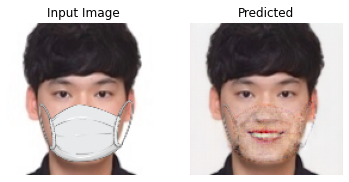

In [ ]:
YM = cv2.imread('/content/JS.JPEG',1)
SIZE=128
YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)

YM = cv2.resize(YM, (SIZE, SIZE))

# normalizing image 
YM = YM.astype('float32') / 255.0
YM = YM.reshape(1,128,128,3)
YM_test = tf.data.Dataset.from_tensor_slices(YM)
YM_test = YM_test.batch(BATCH_SIZE)
for inp in YM_test.take(1):
  prediction = generator(inp, training=True)
  display_list = [inp[0], prediction[0]]
  title = ['Input Image', 'Predicted'] 
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


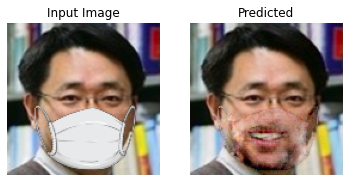

In [ ]:
YM = cv2.imread('/content/JW3.JPEG',1)
SIZE=128
YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)

YM = cv2.resize(YM, (SIZE, SIZE))

# normalizing image 
YM = YM.astype('float32') / 255.0
YM = YM.reshape(1,128,128,3)
YM_test = tf.data.Dataset.from_tensor_slices(YM)
YM_test = YM_test.batch(BATCH_SIZE)
for inp in YM_test.take(1):
  prediction = generator(inp, training=True)
  display_list = [inp[0], prediction[0]]
  title = ['Input Image', 'Predicted'] 
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


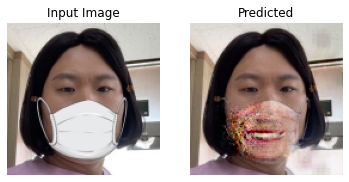

In [ ]:
YM = cv2.imread('/content/YM_pink_resized.jpg',1)
SIZE=128
YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)

YM = cv2.resize(YM, (SIZE, SIZE))

# normalizing image 
YM = YM.astype('float32') / 255.0
YM = YM.reshape(1,128,128,3)
YM_test = tf.data.Dataset.from_tensor_slices(YM)
YM_test = YM_test.batch(BATCH_SIZE)
for inp in YM_test.take(1):
  prediction = generator(inp, training=True)
  display_list = [inp[0], prediction[0]]
  title = ['Input Image', 'Predicted'] 
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


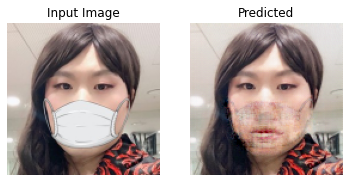

In [ ]:
YM = cv2.imread('/content/YM_red3_resized.jpg',1)
SIZE=128
YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)

YM = cv2.resize(YM, (SIZE, SIZE))

# normalizing image 
YM = YM.astype('float32') / 255.0
YM = YM.reshape(1,128,128,3)
YM_test = tf.data.Dataset.from_tensor_slices(YM)
YM_test = YM_test.batch(BATCH_SIZE)
for inp in YM_test.take(1):
  prediction = generator(inp, training=True)
  display_list = [inp[0], prediction[0]]
  title = ['Input Image', 'Predicted'] 
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


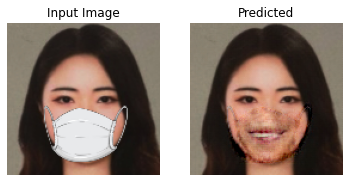

In [ ]:
YM = cv2.imread('/content/gyul3.JPEG',1)
SIZE=128
YM = cv2.cvtColor(YM, cv2.COLOR_BGR2RGB)

YM = cv2.resize(YM, (SIZE, SIZE))

# normalizing image 
YM = YM.astype('float32') / 255.0
YM = YM.reshape(1,128,128,3)
YM_test = tf.data.Dataset.from_tensor_slices(YM)
YM_test = YM_test.batch(BATCH_SIZE)
for inp in YM_test.take(1):
  prediction = generator(inp, training=True)
  display_list = [inp[0], prediction[0]]
  title = ['Input Image', 'Predicted'] 
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()